In [1]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mlresearch.utils import set_matplotlib_style
from recgame.environments import FairEnvironment
from recgame.recourse import NFeatureRecourse
import seaborn as sns
import matplotlib.pyplot as plt

set_matplotlib_style(16)

# Some variables to define the problem
BIAS_FACTOR = 3
RNG_SEED = 55
rng = np.random.default_rng(RNG_SEED)
N_CONTINUOUS = 2
N_AGENTS = 100

# NOTE: Categorical feature will be the "groups" variable; immutable + categorical

# Environment variables
N_LOANS = 10
ADAPTATION = .5
NEW_AGENTS = 10

# NFeatureRecourse for ranking

In [2]:
from copy import deepcopy

class NFeatureRecourseRanking(NFeatureRecourse):
    """
    TODO: Add documentation.
    
    NOTE: This recourse method is designed for ranking models (i.e., linear regressions).
    """
    
    def _get_coefficients(self):
        """Utility function to retrieve model parameters."""

        model = deepcopy(self.model)
        intercept = self.model.intercept_
        coefficients = self.model.coef_

        # Adjusting the intercept to match the desired threshold.
        intercept = 0.5 + intercept - self.threshold
        model.intercept_ = intercept

        return intercept, coefficients, model


# Ranker

In [3]:
class Ranker:
    def __init__(self, coefficients, threshold=0.5):
        self.coefficients = coefficients
        self.threshold = threshold
        
    def fit(self, X, y):
        """This is a placeholder. Should not be used."""
        return self

    def predict(self, X):
        return (self.predict_proba(X) > self.threshold).astype(int).squeeze()
    
    def predict_proba(self, X):
        self.coef_ = np.array(self.coefficients).reshape((1, -1))
        self.intercept_ = 0
        
        return np.dot(X, self.coef_.T)

# Define functions

In [4]:
def get_scaler(n_agents=10_000, n_continuous=2, bias_factor=0, mean=0, std=1/4, random_state=None):
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]
    
    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=mean, scale=std, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=mean+bias_factor*std, scale=std, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    return MinMaxScaler().fit(X)


In [5]:
scaler = get_scaler(
    n_agents=10_000, 
    n_continuous=N_CONTINUOUS, 
    bias_factor=BIAS_FACTOR, 
    random_state=rng
)

In [6]:
def biased_data_generator(n_agents, n_continuous=2, bias_factor=0, mean=0, std=1/4, scaler=None, random_state=None):
    """
    groups feature: 
    - 0 -> Disadvantaged group
    - 1 -> Advantaged group
    
    ``bias_factor`` varies between [0, 1], 0 is completely unbiased, 1 is fully biased.
    """
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]

    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=mean, scale=std, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=mean+bias_factor*std, scale=std, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    
    # TEST: scale continuous features
    if scaler is not None:
        X.loc[:,:] = scaler.transform(X)
    
    X = pd.concat([X, groups], axis=1)
    X = np.clip(X, 0, 1)
    
    # Generate the target
    p0 = 1 / (2 + 2*bias_factor)
    p1 = 1 - p0

    y0 = rng.binomial(1, p0, counts[0])
    y1 = rng.binomial(1, p1, counts[1])
    
    y = pd.concat(
        [
            pd.Series((y0 if val==0 else y1), index=group.index) 
            for val, group in X.groupby("groups")
        ]
    ).sort_index()

    return X, y


In [7]:
def env_biased_data_generator(n_agents):
    return biased_data_generator(n_agents, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng)[0]

In [8]:
from recgame.environments._behavior_functions import ContinuousFlexible


class ContinuousConstantCustom(ContinuousFlexible):
    """Applies continuous adaptation with constant effort."""
    bias_factor_effort_g0 = 0
    bias_factor_effort_g1 = 0
    
    def effort(self, X, global_adaptation):
        """
        Applies constant effort.

        Returns effort rate.
        """
        # Fetch environment variables
        rng = self.environment._rng

        current_effort = (
            self.environment.effort_ if hasattr(self.environment, "effort_") else None
        )

        df_new = (
            self.environment._new_agents
            if hasattr(self.environment, "_new_agents")
            else X
        )

        counts = Counter(df_new["groups"])
        
        x0 = np.abs(rng.normal(0+self.bias_factor_effort_g0, 1, counts[0]))
        x1 = np.abs(rng.normal(0+self.bias_factor_effort_g1, 1, counts[1]))
        
        x = df_new["groups"].copy()
        x.loc[x==0] = x0
        x.loc[x==1] = x1
        x = x.values

        effort_rate = x * global_adaptation / 20
        effort_rate = pd.Series(effort_rate, index=df_new.index)
        effort_rate = pd.concat([current_effort, effort_rate])

        # return pd.Series(effort_rate, index=X.index)
        return effort_rate

    
def behavior_function_generator(bias_factor_effort_g0, bias_factor_effort_g1):
    behav = ContinuousConstantCustom
    behav.bias_factor_effort_g0 = bias_factor_effort_g0
    behav.bias_factor_effort_g1 = bias_factor_effort_g1
    return behav

In [9]:
def fairness_metrics(environment, bins=10, advantaged_pop=1):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    # Get fairness analysis
    fairness_analysis = agents_info.dropna().groupby("groups").mean()
    success_rates = environment.analysis.success_rate(filter_feature="groups")
    fairness_analysis["avg_recourse_reliability"] = success_rates.mean()

    # Get disparity metrics
    not_advantaged = fairness_analysis.index[fairness_analysis.index != advantaged_pop]
    
    if len(not_advantaged) > 1:
        raise NotImplementedError("Only two groups supported.")
    else:
        not_advantaged = not_advantaged[0]
        
    disparates = (fairness_analysis.loc[not_advantaged] / fairness_analysis.loc[advantaged_pop])
    disparates = disparates[["time_for_recourse"]]
    disparates.index = [var for var in disparates.index + "_disparity"]
    disparates["time_for_recourse_disparity"] = (
        fairness_analysis.loc[not_advantaged, "time_for_recourse"] 
        - fairness_analysis.loc[advantaged_pop, "time_for_recourse"]
    )

    # Get Equality of Opportunity
    init_scores = environment.metadata_[0]["score"]
    efforts = []
    for step in environment.metadata_.keys():
        if step == 0:
            continue
            
        eff = (
            environment.outcome(step=step, return_scores=True)[-1]
            - environment.outcome(step=step-1, return_scores=True)[-1]
        )
        eff = eff[eff.index.isin(environment.metadata_[step]["X"].index)]
        eff.fillna(0, inplace=True)
        
        efforts.append((step, eff))

    
    # Used to get the features to calculate EO
    def extract_info(df):
        avg_effort = df["effort"].mean()    
        outcome_rate = df["outcome"].sum() / df.shape[0]
        return pd.Series({"avg_effort": avg_effort, "outcome_rate": outcome_rate})

    eo_per_step = []
    for step, effort in efforts:
        ai_step = agents_info.copy()
        ai_step["effort"] = effort
        ai_step.dropna(subset="effort", inplace=True)    
        ai_step["effort_bins"] = pd.cut(ai_step["effort"], bins)
        ai_step["outcome"] = environment.metadata_[step]["outcome"]
        
        eo = ai_step.groupby(["groups", "effort_bins"], group_keys=True).apply(extract_info)
        eo = eo.reset_index().groupby("groups", group_keys=True).apply(lambda df: (df["outcome_rate"] * df["avg_effort"]).sum() / df["avg_effort"].sum())
        eo = eo.to_frame(step).T
        eo["eo_total"] = eo[not_advantaged] / eo[advantaged_pop]
        eo_per_step.append(eo)
    
    eo_per_step = pd.concat(eo_per_step)
    
    disparates["avg_EO"] = eo_per_step["eo_total"].mean()
    
    if return_eo_only:
        return eo_per_step
    
    return disparates

In [10]:
def fairness_metrics_per_time_step(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    # Get fairness analysis
    fairness_analysis = agents_info.dropna().groupby("groups").mean()
    success_rates = environment.analysis.success_rate(filter_feature="groups")
    sns.lineplot(success_rates)

In [11]:
def fairness_metrics_overall_visualizations(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    results = {}
    
    # ETR - Effort to recourse
    ai_etr = agents_info.dropna(subset="favorable_step")
    ai_etr = ai_etr[ai_etr["n_adaptations"]!=0]

    ai_etr["total_effort"] = ai_etr["final_score"] - ai_etr["original_score"]
    etr = ai_etr.groupby("groups").mean()["total_effort"]
    results["etr_disparity"] = etr.loc[0] / etr.loc[1]    
    
    # TTR
    ttr = ai_etr.groupby("groups").mean()["time_for_recourse"]
    results["disparate_ttr"] = ttr.loc[0] - ttr.loc[1]

    sns.boxplot(data=ai_etr, x="groups", y="total_effort")
    plt.show()
    
    sns.boxplot(data=ai_etr, x="groups", y="time_for_recourse")
    plt.show()

    return results


In [12]:
def fairness_metrics_overall(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    results = {}
    
    # ETR - Effort to recourse
    ai_etr = agents_info.dropna(subset="favorable_step")
    ai_etr = ai_etr[ai_etr["n_adaptations"]!=0]

    ai_etr["total_effort"] = ai_etr["final_score"] - ai_etr["original_score"]
    etr = ai_etr.groupby("groups").mean()["total_effort"]
    results["etr_disparity"] = etr.loc[0] / etr.loc[1]    
    
    # TTR
    ttr = ai_etr.groupby("groups").mean()["time_for_recourse"]
    results["disparate_ttr"] = ttr.loc[0] - ttr.loc[1]
    
    return results


# Experiments (Standard Environment)

In [13]:
df, y = biased_data_generator(N_AGENTS, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng)
categorical = ["groups"]

model = Ranker(coefficients=[.5, .5, 0])

<Axes: ylabel='Count'>

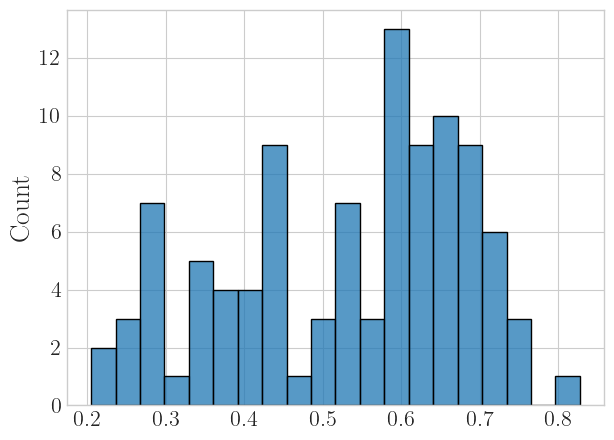

In [14]:
sns.histplot(model.predict_proba(df)[:,0],bins=20)

Original classes:
 groups   
0       0    34
        1     5
1       0     9
        1    52
dtype: int64
Predicted classes:
 groups   
0       0    36
        1     3
1       0     1
        1    60
dtype: int64


<Axes: title={'center': 'f1'}, ylabel='Frequency'>

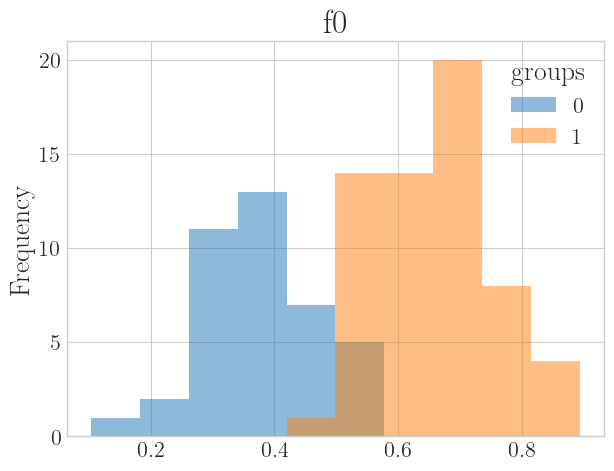

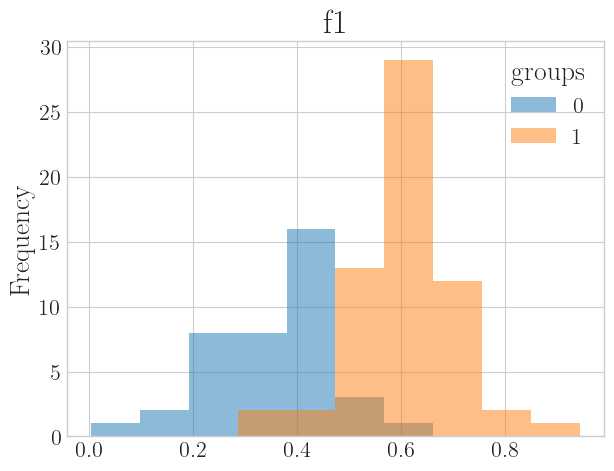

In [15]:
print("Original classes:\n", df.groupby(["groups", y]).size())
print("Predicted classes:\n", df.groupby(["groups", model.predict(df)]).size())
df.pivot(columns="groups")["f0"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f0")
df.pivot(columns="groups")["f1"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f1")

In [16]:
df.min(), df.max()

(f0        0.103162
 f1        0.004925
 groups    0.000000
 dtype: float64,
 f0        0.894431
 f1        0.943923
 groups    1.000000
 dtype: float64)

In [17]:
# Define the necessary components to run simulation
recourse = NFeatureRecourseRanking(model, categorical=["groups"], immutable=["groups"])
recourse.set_actions(df)
recourse.action_set_.lb = [-0.1, -0.1, 0]
recourse.action_set_.ub = [1.1, 1.1, 1]

environment = FairEnvironment(
    X=df,
    recourse=recourse,
    group_feature="groups",
    data_source_func=env_biased_data_generator,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="continuous_constant",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(20)

FairEnvironment(X=          f0        f1  groups
0   0.700676  0.575592       1
1   0.818148  0.627632       1
2   0.484552  0.391775       0
3   0.276622  0.217318       0
4   0.392280  0.380684       0
..       ...       ...     ...
95  0.637868  0.745771       1
96  0.526699  0.637380       1
97  0.571567  0.634100       1
98  0.500015  0.690801       1
99  0.437079  0.435081       0

[100 rows x 3 columns],
                adaptation=0.5, behavior_function='continuous_constant',
                data_source_func=<function env_biased_data_generator at 0x7fe22a19c280>,
                group_feature='groups', growth_rate=10,
                growth_rate_type='absolute', random_state=55,
                recourse=NFeatureRecourseRanking(categorical=['groups'],
                                                 immutable=['groups'],
                                                 model=<__main__.Ranker object at 0x7fe227e9be20>,
                                                 threshold=0.8398540321457133),
                threshold=10)

# Visualization and analysis (Standard Environment)

In [18]:
from matplotlib.colors import ListedColormap
environment.plot._favorable = ListedColormap(["#40b27f", "green"])
environment.plot._unfavorable = ListedColormap(["#51a3ef", "blue"])
environment.plot._previous = ListedColormap(["#be4d65", "red"])

<Axes: title={'center': 'Population scores over 21 time steps'}, xlabel='Step', ylabel='Score'>

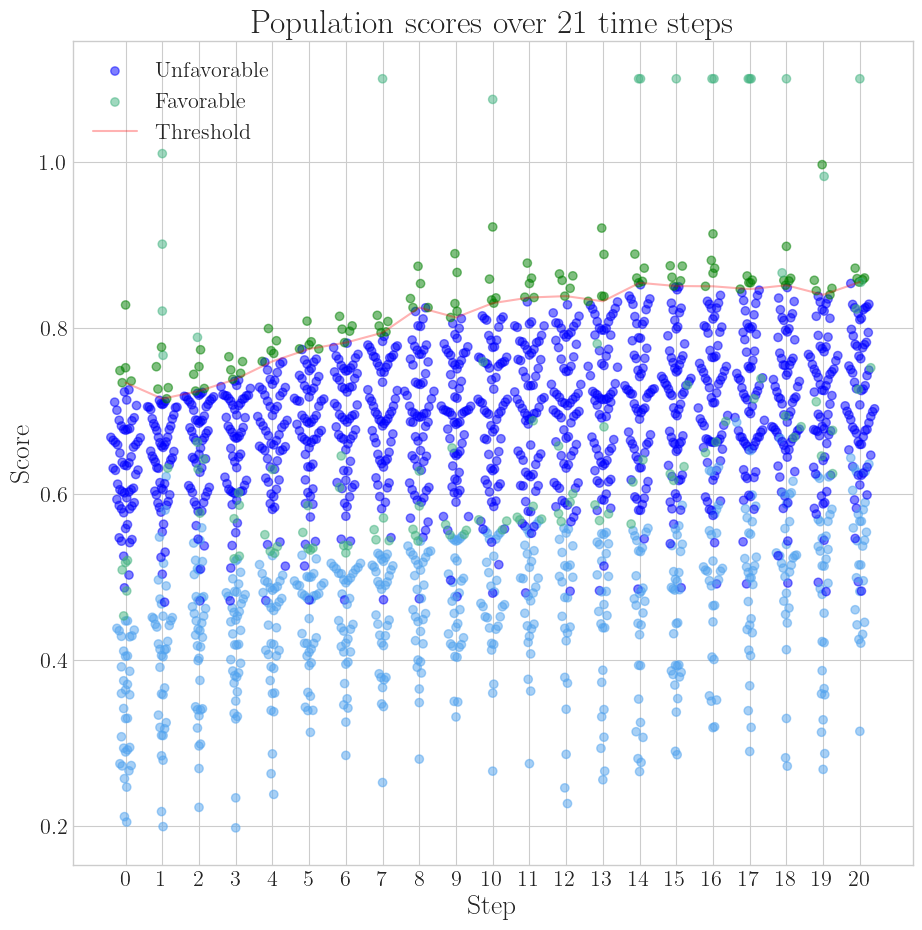

In [19]:
environment.plot.agent_scores(color_feature="groups")

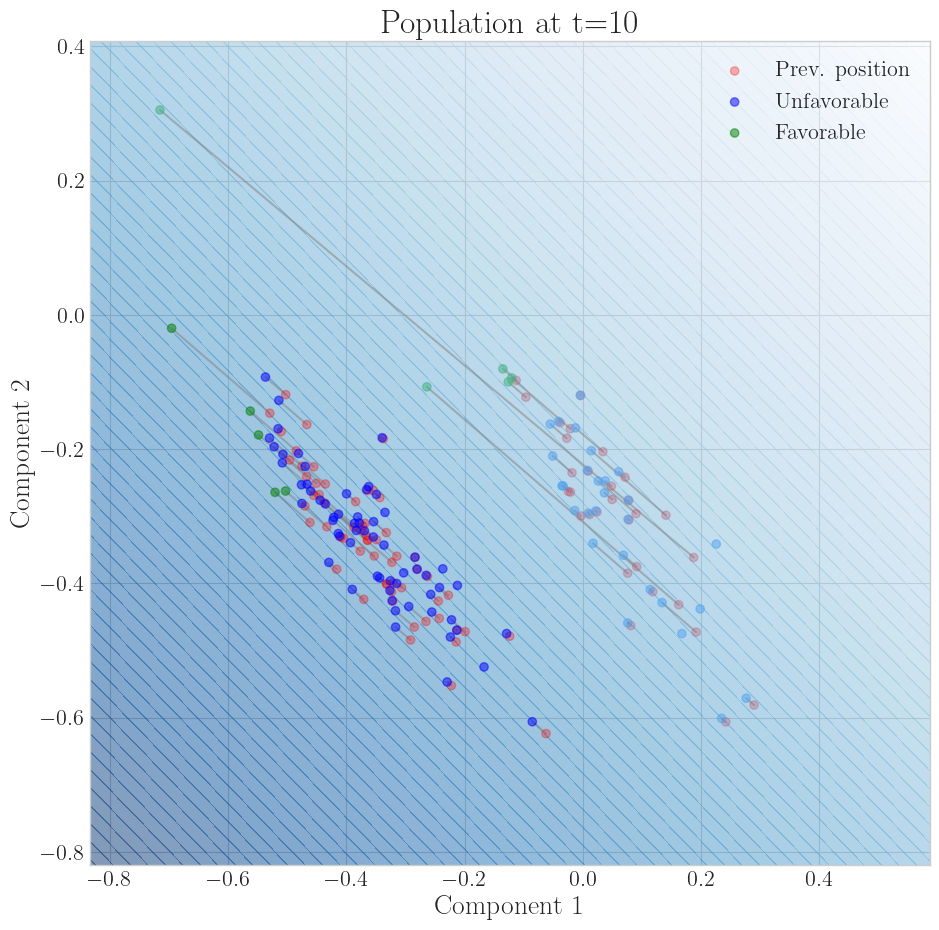

In [20]:
ax = environment.plot.scatter(10, color_feature="groups")

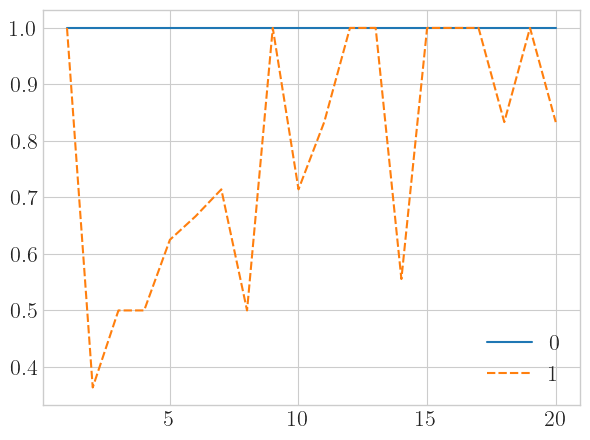

In [21]:
fairness_metrics_per_time_step(environment)

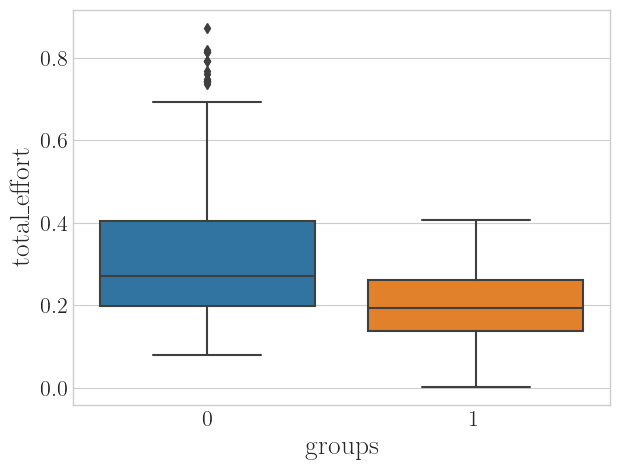

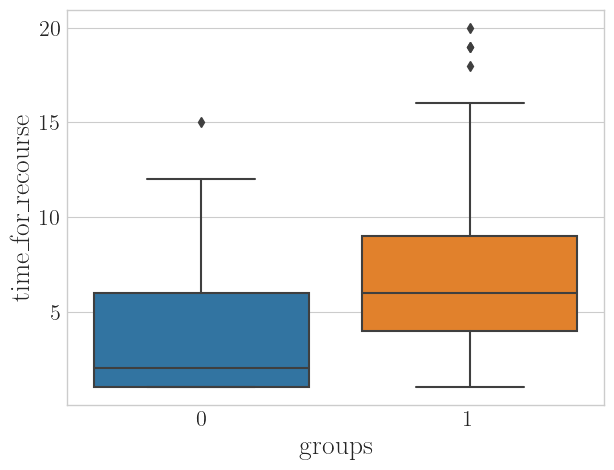

{'etr_disparity': 1.7310998444156935, 'disparate_ttr': -3.0798804370232937}

In [22]:
fairness_metrics_overall_visualizations(environment)
# Boxplots for different qualification values

In [23]:
fairness_metrics(environment)

NameError: name 'return_eo_only' is not defined

# Draft code

In [ ]:
df_fair

In [ ]:
df_fair_grouped = df_fair.groupby(["groups", "effort_bins"]).mean()
df_fair_grouped["size"] = df_fair.groupby(["groups", "effort_bins"]).size()
# df_fair_grouped.loc[1]
# df_fair_grouped.loc[0]
df_fair_grouped

In [ ]:
environment.metadata_[5]["threshold_index"]
environment.metadata_[5]["effort"]

In [ ]:
df

In [ ]:
counts = Counter(df["groups"])

In [ ]:
Counter(environment.X_.groups)

In [ ]:
Counter(environment.get_all_agents().groups)